In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Activation, Flatten
from keras.utils import to_categorical
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing


In [4]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('../project_datasets',num_validation=50, num_test=0, subtract_mean=True, subtract_axis=1,
                transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2508, 1000, 22) 
y_train: (2508,) 
X_val: (50, 1000, 22) 
y_val: (50,) 
X_test: (0, 1000, 22) 
y_test: (0,) 


In [27]:
num_classes = 4

# substract data from list
X_train = data.get('X_train')
y_train = data.get('y_train')
X_val = data.get('X_val')
y_val = data.get('y_val')

# get data dimension
N_train, T_train, C_train = data.get('X_train').shape
N_val, T_val, C_val = data.get('X_val').shape

# add dummy zeros for y classification, convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [45]:
# construct X_total and y_total based on sub-sampling of X_train and y_train

# take sub-sampling on the time sequence to reduce dimension for RNN
sampling = 1

X_train = X_train.reshape(N_train,int(T_train/sampling), sampling, C_train)[:,:,0,:]
X_val = X_val.reshape(N_val,int(T_val/sampling), sampling, C_val)[:,:,0,:]
    
# get new data dimension
N_train, T_train, C_train = X_train.shape
N_val, T_val, C_val = X_val.shape

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)

X_train:  (2508, 1000, 22)
y_train:  (2508, 4)
X_val:  (50, 1000, 22)
y_val:  (50, 4)


In [46]:
# Expected input batch shape: (batch_size, timesteps, data_dim)
# Note that we have to provide the full batch_input_shape since the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
timesteps = T_train
batch_size = 50
num_epoch = 200

# make a sequential model
model = Sequential()

# add 1-layer cnn
model.add(Conv1D(40, kernel_size=12, strides=4,
          input_shape=(timesteps, data_dim)))
model.add(Activation('relu'))
model.add(Dropout(0.75))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4, strides=4))


# add 2-layer lstm
model.add(LSTM(20, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(20, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# set loss function and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [47]:
# train the data with validation
history = model.fit(X_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epoch, 
                    shuffle=False,
                    validation_data=(X_val, y_val))

Train on 2508 samples, validate on 50 samples
Epoch 1/200
2508/2508 [==============================] - 7s 3ms/step - loss: 1.8512 - acc: 0.2648 - val_loss: 1.4604 - val_acc: 0.2600
Epoch 2/200
2508/2508 [==============================] - 5s 2ms/step - loss: 1.6883 - acc: 0.2775 - val_loss: 1.3194 - val_acc: 0.3600
Epoch 3/200
2508/2508 [==============================] - 6s 2ms/step - loss: 1.5806 - acc: 0.3118 - val_loss: 1.2655 - val_acc: 0.4400
Epoch 4/200
2508/2508 [==============================] - 6s 2ms/step - loss: 1.5420 - acc: 0.3054 - val_loss: 1.1811 - val_acc: 0.4600
Epoch 5/200
2508/2508 [==============================] - 5s 2ms/step - loss: 1.4571 - acc: 0.3409 - val_loss: 1.2134 - val_acc: 0.4600
Epoch 6/200
2508/2508 [==============================] - 5s 2ms/step - loss: 1.4558 - acc: 0.3449 - val_loss: 1.1742 - val_acc: 0.5000
Epoch 7/200
2508/2508 [==============================] - 5s 2ms/step - loss: 1.4055 - acc: 0.3501 - val_loss: 1.1762 - val_acc: 0.4800
Epoch 8/2

Epoch 61/200
2508/2508 [==============================] - 5s 2ms/step - loss: 0.8853 - acc: 0.6376 - val_loss: 0.8455 - val_acc: 0.7000
Epoch 62/200
2508/2508 [==============================] - 5s 2ms/step - loss: 0.8656 - acc: 0.6523 - val_loss: 1.0007 - val_acc: 0.5800
Epoch 63/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.8797 - acc: 0.6547 - val_loss: 0.9833 - val_acc: 0.6000
Epoch 64/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.8408 - acc: 0.6659 - val_loss: 0.9668 - val_acc: 0.6200
Epoch 65/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.8631 - acc: 0.6499 - val_loss: 0.9384 - val_acc: 0.6200
Epoch 66/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.8476 - acc: 0.6571 - val_loss: 0.9140 - val_acc: 0.6000
Epoch 67/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.8321 - acc: 0.6647 - val_loss: 0.9738 - val_acc: 0.6000
Epoch 68/200
2508/2508 [========================

2508/2508 [==============================] - 5s 2ms/step - loss: 0.6928 - acc: 0.7253 - val_loss: 1.1068 - val_acc: 0.6000
Epoch 122/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.6811 - acc: 0.7313 - val_loss: 1.1222 - val_acc: 0.6800
Epoch 123/200
2508/2508 [==============================] - 5s 2ms/step - loss: 0.6708 - acc: 0.7392 - val_loss: 0.9957 - val_acc: 0.6200
Epoch 124/200
2508/2508 [==============================] - 5s 2ms/step - loss: 0.6761 - acc: 0.7348 - val_loss: 1.0548 - val_acc: 0.5800
Epoch 125/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.6819 - acc: 0.7285 - val_loss: 1.0337 - val_acc: 0.6400
Epoch 126/200
2508/2508 [==============================] - 5s 2ms/step - loss: 0.6490 - acc: 0.7444 - val_loss: 1.1101 - val_acc: 0.6200
Epoch 127/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.6459 - acc: 0.7380 - val_loss: 0.9366 - val_acc: 0.6600
Epoch 128/200
2508/2508 [==============================

Epoch 181/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.5779 - acc: 0.7767 - val_loss: 0.9902 - val_acc: 0.6400
Epoch 182/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.5736 - acc: 0.7763 - val_loss: 1.0736 - val_acc: 0.6200
Epoch 183/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.5982 - acc: 0.7723 - val_loss: 0.9263 - val_acc: 0.6400
Epoch 184/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.5476 - acc: 0.7919 - val_loss: 0.9973 - val_acc: 0.6200
Epoch 185/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.5648 - acc: 0.7811 - val_loss: 0.9431 - val_acc: 0.7000
Epoch 186/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.5917 - acc: 0.7707 - val_loss: 0.8933 - val_acc: 0.7000
Epoch 187/200
2508/2508 [==============================] - 6s 2ms/step - loss: 0.5857 - acc: 0.7771 - val_loss: 0.8762 - val_acc: 0.7200
Epoch 188/200
2508/2508 [================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


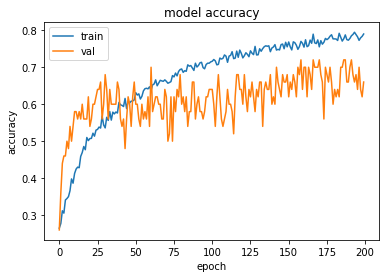

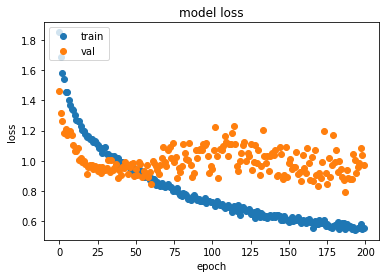

In [48]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()